# Exploring how to train FrozenM2M100Model with Avalanche

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cd_home = os.getcwd() == '/Users/emmanuelrassou/Desktop/HarvardClasses/spring_2025/neuro_240/final_project'
if not cd_home:
    os.chdir("..")  # Move one directory up
    print("Moved up one directory:", os.getcwd())  # Check current directory
    print("Contents of directory:", os.listdir())  # Equivalent to `%ls`

cd_home = True

Moved up one directory: /Users/emmanuelrassou/Desktop/HarvardClasses/spring_2025/neuro_240/final_project
Contents of directory: ['nohup_300_5.out', '.myenv', '.DS_Store', 'core', 'requirements.txt', 'loss.txt', 'strategy_5_200', 'nohup_200_4.out', 'VAE_output_per_exp.png', 'images', 'dataset', 'run_experiments.sh', 'fairseq', 'ar1-pytorch', 'training_demo.sh', 'modern_latent_replay', 'old_01.out', 'loss_01.txt', 'loss_03.txt', 'loss_02.txt', 'model', 'Assignment 3_ Midterm Report.pdf', 'predictions.txt', 'miniforge.sh', 'Combatting Language Forgetting in MultiLingual Settings.pdf', '.vscode', 'strategy_5_0', 'avalanche_demo', 'small_100', 'strategy_5_300']


In [3]:
import argparse
import torch
from torch.nn import CrossEntropyLoss

from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
import avalanche.models.utils

from core.latent_replay_transformer import LatentReplayTransformer
import model.utils

import sys
import os
from small_100.modeling_m2m_100 import M2M100Model

/Users/emmanuelrassou/miniforge3-arm64/envs/avalanche-arm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# For Apple Metal
device = torch.device(
    f"mps" if torch.backends.mps.is_available() else "cpu"
)
device

device(type='mps')

# Evaluating the model

In [17]:
interactive_logger = InteractiveLogger()

bleu_metric = model.utils.BLEUMetric()

eval_plugin = EvaluationPlugin(
    bleu_metric,
    loggers=[interactive_logger])

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Training

## Loss Function

In [6]:
# Create dummy data
# For CrossEntropyLoss, we need:
# - predictions (logits): shape [batch_size, num_classes]
# - targets: shape [batch_size] with class indices

# Parameters
batch_size = 3
num_classes = 5

# Create random logits (raw model outputs before softmax)
logits = torch.randn(batch_size, num_classes)
print("Logits (raw model predictions):")
print(logits)

# Create random target labels (integers between 0 and num_classes-1)
targets = torch.randint(0, num_classes, (batch_size,))
print("\nTarget labels (ground truth):")
print(targets)

# Initialize the loss function
loss_fn = CrossEntropyLoss()

# Calculate the loss
loss = loss_fn(logits, targets)

# Verify manually to check if it's working correctly
# CrossEntropyLoss combines LogSoftmax and NLLLoss
softmax_logits = torch.nn.functional.softmax(logits, dim=1)
print("\nSoftmax probabilities:")
print(softmax_logits)
print("Row sums (should be 1):", softmax_logits.sum(dim=1))

log_softmax = torch.nn.functional.log_softmax(logits, dim=1)
manual_loss = 0
for i in range(batch_size):
    manual_loss -= log_softmax[i, targets[i]]
manual_loss /= batch_size

print("\nCrossEntropyLoss computed by PyTorch:", loss.item())
print("Manually computed loss:", manual_loss.item())

Logits (raw model predictions):
tensor([[ 0.7142,  1.7886,  1.8330, -0.6964, -0.4726],
        [-0.2353, -0.0648,  0.5455, -0.4797, -1.1143],
        [-0.7260, -0.3128,  0.3078, -1.2127, -0.8351]])

Target labels (ground truth):
tensor([0, 0, 0])

Softmax probabilities:
tensor([[0.1326, 0.3884, 0.4061, 0.0324, 0.0405],
        [0.1796, 0.2130, 0.3921, 0.1407, 0.0746],
        [0.1463, 0.2212, 0.4114, 0.0899, 0.1312]])
Row sums (should be 1): tensor([1.0000, 1.0000, 1.0000])

CrossEntropyLoss computed by PyTorch: 1.8863306045532227
Manually computed loss: 1.886330485343933


## Training Strategy

In [27]:

LATENT_LAYER_NUM = 5
strategy_config = {
    "device": device,
    "criterion": CrossEntropyLoss(),
    "evaluator": eval_plugin,
    "lr": 1e-4,
    "train_mb_size":4,
    "eval_mb_size": 4,
    "latent_layer_num": LATENT_LAYER_NUM,
    "max_seq_len": 128,
    "freeze_below_layer": f"encoder.layers.{LATENT_LAYER_NUM}.self_attn.k_proj",
    "warmup_steps": 4000,
    "train_epochs": 1,
    "pretrained": True,
}

In [ ]:
vanilla_strategy = LatentReplayTransformer(**strategy_config, rm_sz = 0)



Loading pretrained model...


Some weights of M2M100Model were not initialized from the model checkpoint at alirezamsh/small100 and are newly initialized: ['model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
save_m2m100_model(vanilla_strategy.model, "vanilla_model")

Model saved to vanilla_model


## Preparing datasets

In [8]:
from dataset.load_flores200 import get_flores200_benchmark
src_languages = ["eng_Latn", "ita_Latn", "afr_Latn"]  # Example source languages
tgt_language = "fra_Latn"

scenario = get_flores200_benchmark(src_languages, tgt_language, max_seq_len=128, demo_subset=5)

In [9]:
# explore benchmark
for experience in scenario.train_stream:
    print(f"Experience {experience.current_experience} - Dataset size: {len(experience.dataset)}")

Experience 0 - Dataset size: 5
Experience 1 - Dataset size: 5
Experience 2 - Dataset size: 5


## Training Loop

In [10]:
def train_with_eval(strategy, scenario):
    print('Starting experiment...')
    results = []

    seen_experiences = []
    for experience in scenario.train_stream:
        print(f"Start of experience {experience.current_experience}")
        seen_experiences.append(experience.current_experience)

        # Train on the current experience
        strategy.train(experience, num_workers=0)
        print('Training completed')

        # Evaluate on the corresponding test set
        print(f'Computing accuracy on test sets: {seen_experiences}')
        test_experiences = [scenario.test_stream[exp] for exp in seen_experiences]
        results.append(strategy.eval(test_experiences))
    return results

In [11]:
replay_strategy = LatentReplayTransformer(**strategy_config, rm_sz=1500)
train_with_eval(replay_strategy, scenario)

Loading pretrained model...


Some weights of M2M100Model were not initialized from the model checkpoint at alirezamsh/small100 and are newly initialized: ['model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting experiment...
Start of experience 0
-- >> Start of training phase << --
Frozen layers:
 {'encoder.layers.1.final_layer_norm', 'encoder.layers.1.fc1', 'encoder.layers.2.self_attn.q_proj', 'encoder.layers.4.self_attn_layer_norm', 'encoder.layers.0.self_attn.k_proj', 'encoder.layers.0.self_attn.q_proj', 'encoder.layers.2.self_attn.out_proj', 'encoder.layers.1.self_attn.q_proj', 'encoder.layers.0.fc2', 'encoder.layers.3.fc1', 'encoder.layers.4.fc2', 'encoder.layers.0.self_attn_layer_norm', 'encoder.layers.1.self_attn.out_proj', 'encoder.layers.2.self_attn.k_proj', 'encoder.layers.3.self_attn.q_proj', 'encoder.layers.2.fc1', 'encoder.layers.1.fc2', 'encoder.layers.3.self_attn.k_proj', 'encoder.layers.4.final_layer_norm', 'encoder.layers.3.fc2', 'encoder.layers.4.self_attn.q_proj', 'encoder.layers.2.fc2', 'encoder.layers.3.self_attn.out_proj', 'encoder.layers.0.self_attn.v_proj', 'encoder.layers.2.self_attn.v_proj', 'encoder.layers.1.self_attn.v_proj', 'encoder.layers.2.self_attn_la

[{'BLEU': 0.0},
 {'BLEU': 8.60253526584218e-233},
 {'BLEU': 5.5005174187624985e-232}]

In [12]:
vanilla_strategy = LatentReplayTransformer(**strategy_config, rm_sz = 0)
train_with_eval(vanilla_strategy, scenario)

Loading pretrained model...


Some weights of M2M100Model were not initialized from the model checkpoint at alirezamsh/small100 and are newly initialized: ['model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting experiment...
Start of experience 0
-- >> Start of training phase << --
Frozen layers:
 {'encoder.layers.1.final_layer_norm', 'encoder.layers.1.fc1', 'encoder.layers.2.self_attn.q_proj', 'encoder.layers.4.self_attn_layer_norm', 'encoder.layers.0.self_attn.k_proj', 'encoder.layers.0.self_attn.q_proj', 'encoder.layers.2.self_attn.out_proj', 'encoder.layers.1.self_attn.q_proj', 'encoder.layers.0.fc2', 'encoder.layers.3.fc1', 'encoder.layers.4.fc2', 'encoder.layers.0.self_attn_layer_norm', 'encoder.layers.1.self_attn.out_proj', 'encoder.layers.2.self_attn.k_proj', 'encoder.layers.3.self_attn.q_proj', 'encoder.layers.2.fc1', 'encoder.layers.1.fc2', 'encoder.layers.3.self_attn.k_proj', 'encoder.layers.4.final_layer_norm', 'encoder.layers.3.fc2', 'encoder.layers.4.self_attn.q_proj', 'encoder.layers.2.fc2', 'encoder.layers.3.self_attn.out_proj', 'encoder.layers.0.self_attn.v_proj', 'encoder.layers.2.self_attn.v_proj', 'encoder.layers.1.self_attn.v_proj', 'encoder.layers.2.self_attn_la

[{'BLEU': 0.0}, {'BLEU': 0.0}, {'BLEU': 0.0}]

# Plotting Experiments

[[(0, 15.47348690032959), (1, 16.463354110717773), (2, 15.791491508483887), (3, 16.17041015625), (4, 17.98762321472168), (5, 16.544252395629883), (6, 17.36961555480957), (7, 16.91880989074707), (8, 18.316946029663086), (9, 19.125518798828125), (10, 18.45711898803711), (11, 19.37309455871582), (12, 19.369855880737305), (13, 19.790563583374023), (14, 17.875045776367188), (15, 18.89645767211914), (16, 18.39478302001953), (17, 17.78834342956543), (18, 18.933700561523438), (19, 17.527097702026367), (20, 17.597213745117188), (21, 18.639806747436523), (22, 18.186723709106445), (23, 17.89313316345215), (24, 17.677587509155273), (25, 18.79842758178711), (26, 16.567550659179688), (27, 17.999732971191406), (28, 16.179359436035156), (29, 17.549728393554688), (30, 16.757858276367188), (31, 15.889394760131836), (32, 14.960192680358887), (33, 15.643526077270508), (34, 14.513948440551758), (35, 15.909116744995117), (36, 15.556501388549805), (37, 12.87817668914795), (38, 14.693161010742188), (39, 13.88

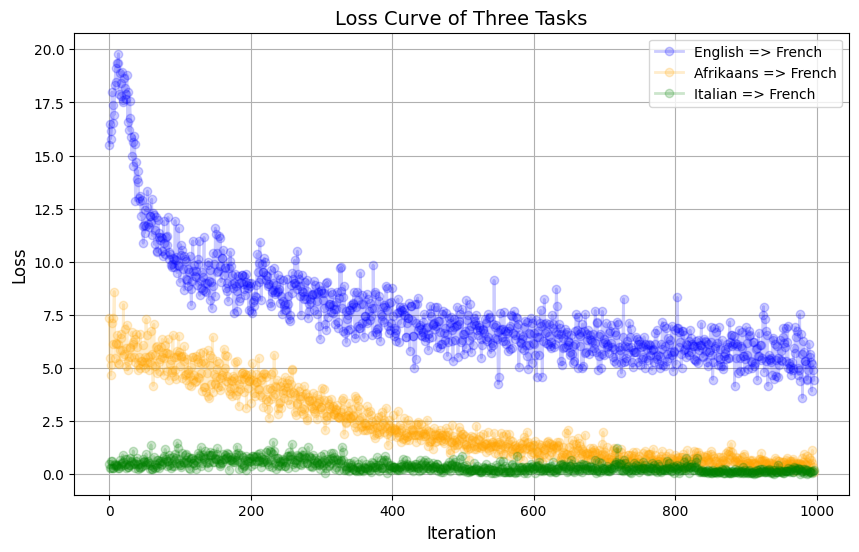

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curve(file_path):
    """
    Reads a loss log file with format: iteration,loss and plots the loss curve.

    Parameters:
    - file_path (str): Path to the loss.txt file

    Returns:
    - None (displays the plot)
    """
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Parse both loss streams
    loss_streams = []
    current_stream = []
    last_iter = -1


    for line in lines:
        if not line.strip():
            continue
        try:
            iter_str, loss_str = line.strip().split(",")
            iteration = int(iter_str)
            loss = float(loss_str)

            # New stream starts if iteration resets
            if iteration <= last_iter:
                loss_streams.append(current_stream)
                current_stream = []

            current_stream.append((iteration, loss))
            last_iter = iteration
        except ValueError:
            continue

    if current_stream:
        loss_streams.append(current_stream)
    print(loss_streams)
    # Convert to DataFrames
    stream1 = pd.DataFrame(loss_streams[0], columns=["Iteration", "Loss"])
    stream2 = pd.DataFrame(loss_streams[1], columns=["Iteration", "Loss"])
    stream3 = pd.DataFrame(loss_streams[2], columns=["Iteration", "Loss"])
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(stream1["Iteration"], stream1["Loss"], marker='o', linewidth=2, label="English => French", color="blue", alpha=0.2)
    plt.plot(stream2["Iteration"], stream2["Loss"], marker='o', linewidth=2, label="Afrikaans => French", color="orange", alpha=0.2)
    plt.plot(stream3["Iteration"], stream3["Loss"], marker='o', linewidth=2, label="Italian => French", color="green", alpha=0.2)
    plt.title("Loss Curve of Three Tasks", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True)
    plt.legend()
    # plt.tight_layout()
    plt.savefig("loss_curve_eng_afr_fra.png")
    plt.show()

plot_loss_curve("loss.txt")

In [5]:
bleumetric = model.utils.BLEUMetric()
predicted = "suits are normal livere, phot topers call each other by their or by website specialles."
ref = "Suits are standard business attire, coworkers call each other by their family names or by job titles."
bleumetric.update(ref, predicted)

print(bleumetric.compute())

0.2560418203788593
